In [1]:
import pandas as pd
pd.options.display.float_format = '{:.6g}'.format
import scipy.cluster.hierarchy
import scipy.spatial.distance
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import warnings
warnings.filterwarnings('ignore')
from hrp import HRP
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time

# OOS PERFORMANCE

In [2]:
def get_oos_ret_freq(data, start_date, end_date, freq="M"):
    """
    Get Out of Sample data in returns format for each frequency period.
    
    Args:
        data (pd.DataFrame): Input data with 'Date' column and asset returns
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format 
        freq (str): Frequency for resampling ('M' for monthly, 'W' for weekly etc)
        
    Returns:
        pd.DataFrame: Resampled returns dataframe with portfolio returns columns
    """
    # Filter data for date range
    filter_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    filter_data.set_index('Date', inplace=True)
    
    # Calculate returns and handle missing values
    returns_df = filter_data.pct_change()
    returns_df = returns_df.dropna(how="all").dropna(axis=1, how="all").fillna(0)
    
    # Convert to cumulative returns for the frequency period
    adj_ret = returns_df + 1
    adj_ret_freq = adj_ret.groupby(adj_ret.index.to_period(freq)).cumprod()
    ret_freq = adj_ret_freq.resample(freq).last().fillna(0)
    
    # Initialize portfolio return columns
    ret_freq[['EQ_Ret','HRP_Ret','RP_Ret','MV_Ret']] = 0
    
    return ret_freq

def get_rolling_returns(main_data, data_oos, lookback_days):
    """
    Calculate rolling returns and weight variances using different portfolio strategies.
    
    Args:
        main_data (pd.DataFrame): Complete dataset for training
        data_oos (pd.DataFrame): Out of sample data for testing
        lookback_days (int): Number of days to use for training window
        
    Returns:
        tuple: (Portfolio returns DataFrame, Weight variance DataFrame)
    """
    start_timer = time.time()
    
    # Initialize weight DataFrames
    weight_dfs = {
        'HRP': pd.DataFrame(),
        'RP': pd.DataFrame(), 
        'MV': pd.DataFrame()
    }
    
    # Calculate equal weight portfolio returns
    num_assets = data_oos.shape[1] - 4
    eq_weights = 1/num_assets
    data_oos['EQ_Ret'] = np.sum(data_oos.iloc[:,:num_assets] * eq_weights, axis=1)

    # Calculate rolling returns for each date
    for i, date in enumerate(data_oos.index):
        # Get training period dates
        end_date_train = (date.replace(day=1) - timedelta(days=1))
        start_date_train = end_date_train - relativedelta(days=lookback_days)
        
        end_date_train = end_date_train.strftime("%Y-%m-%d")
        start_date_train = start_date_train.strftime("%Y-%m-%d")

        # Print progress
        if (i+1)%5==0 or (i==0):
            print(f"Starting train iteration {i+1}. Start: {start_date_train}. End: {end_date_train}")

        # Calculate portfolio weights
        hrp_oos = HRP(prior_data=main_data, start_date=start_date_train, end_date=end_date_train)
        weights = {
            'HRP': pd.Series(hrp_oos.calculate_hrp_weights()),
            'RP': pd.Series(hrp_oos.calculate_RP_weights()),
            'MV': pd.Series(hrp_oos.calculate_MV_weights())
        }
        
        # Store weights and calculate returns
        for method, w in weights.items():
            weight_dfs[method] = pd.concat([weight_dfs[method], w], axis=1)
            data_oos.loc[date, f'{method}_Ret'] = np.sum(data_oos.iloc[i,:num_assets] * w)
    
    # Calculate weight variances
    weight_var = {method: np.mean(df.T.var()) for method, df in weight_dfs.items()}
    weight_var_df = pd.DataFrame(weight_var, index=["Variance"]).T

    print(f"Time Taken for training: {time.time()-start_timer:.4f} sec")
    
    return data_oos[['EQ_Ret','HRP_Ret','RP_Ret','MV_Ret']], weight_var_df

def get_ret_stats(roll_df):
    """
    Calculate mean and variance statistics for portfolio returns.
    
    Args:
        roll_df (pd.DataFrame): Portfolio returns DataFrame
        
    Returns:
        pd.DataFrame: Mean and variance statistics
    """
    return pd.DataFrame({
        'Mean': roll_df.mean(),
        'Variance': roll_df.var()
    }).T


### EQUITIES

In [3]:
stock_data = pd.read_csv('data/sp500v2.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

start_stock_oos = '2024-01-01'
end_stock_oos= '2024-12-31'

oos_stock_data = get_oos_ret_freq(stock_data,start_stock_oos,end_stock_oos,"M")
rolling_returns_stock, weight_var_stock = get_rolling_returns(stock_data,oos_stock_data, 2*365)
equity_stats = get_ret_stats(rolling_returns_stock)

Starting train iteration 1. Start: 2021-12-31. End: 2023-12-31
Starting train iteration 5. Start: 2022-05-01. End: 2024-04-30
Starting train iteration 10. Start: 2022-10-01. End: 2024-09-30
Time Taken for training: 12.5091 sec


In [4]:
rolling_returns_stock.head(5)

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2024-01-31,0.997307,0.996151,0.996808,1.01126
2024-02-29,1.04454,1.03766,1.03627,0.497857
2024-03-31,1.04601,1.04389,1.04332,0.835641
2024-04-30,0.952252,0.95623,0.958598,0.767431
2024-05-31,1.02973,1.02301,1.02678,0.836609


In [5]:
equity_stats

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Mean,1.01243,1.01167,1.01207,0.936131
Variance,0.00153719,0.00140591,0.00142733,0.0539252


In [6]:
weight_var_stock

,Variance
HRP,3.17073e-06
RP,2.68335e-07
MV,0.0684863


### COMMODITIES

In [7]:
comm_data = pd.read_csv('data/commodities_data.csv')
comm_data['Date'] = pd.to_datetime(comm_data['Date'])

start_comm_oos = '2019-01-01'
end_comm_oos= '2024-12-31'

oos_comm_data = get_oos_ret_freq(comm_data,start_comm_oos,end_comm_oos,"M")
rolling_returns_comm, weight_var_comm = get_rolling_returns(comm_data,oos_comm_data, 2*365)
comm_stats = get_ret_stats(rolling_returns_comm)

Starting train iteration 1. Start: 2016-12-31. End: 2018-12-31
Starting train iteration 5. Start: 2017-04-30. End: 2019-04-30
Starting train iteration 10. Start: 2017-09-30. End: 2019-09-30
Starting train iteration 15. Start: 2018-03-01. End: 2020-02-29
Starting train iteration 20. Start: 2018-08-01. End: 2020-07-31
Starting train iteration 25. Start: 2019-01-01. End: 2020-12-31
Starting train iteration 30. Start: 2019-06-01. End: 2021-05-31
Starting train iteration 35. Start: 2019-11-01. End: 2021-10-31
Starting train iteration 40. Start: 2020-03-31. End: 2022-03-31
Starting train iteration 45. Start: 2020-08-31. End: 2022-08-31
Starting train iteration 50. Start: 2021-01-31. End: 2023-01-31
Starting train iteration 55. Start: 2021-06-30. End: 2023-06-30
Starting train iteration 60. Start: 2021-11-30. End: 2023-11-30
Starting train iteration 65. Start: 2022-05-01. End: 2024-04-30
Starting train iteration 70. Start: 2022-10-01. End: 2024-09-30
Time Taken for training: 1.2208 sec


In [8]:
rolling_returns_comm.head(5)

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2019-01-31,1.03364,1.03606,1.03366,1.03363
2019-02-28,1.01102,1.00329,0.997027,1.01272
2019-03-31,1.01024,0.995278,0.993784,0.996658
2019-04-30,0.997369,0.989207,0.989263,0.99079
2019-05-31,0.999773,1.00739,1.01868,1.0286


In [9]:
comm_stats

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Mean,1.01077,1.00884,1.00971,1.01034
Variance,0.00274263,0.00146999,0.00144529,0.000947282


In [10]:
weight_var_comm

,Variance
HRP,0.000645423
RP,0.00101096
MV,0.00390915


### INDEXES

In [11]:
ind_data = pd.read_csv('data/daily_index_data_last_5_years.csv')
ind_data['Date'] = pd.to_datetime(ind_data['Date'])

start_ind_oos = '2019-01-01'
end_ind_oos= '2024-12-31'

oos_ind_data = get_oos_ret_freq(ind_data,start_ind_oos,end_ind_oos,"M")
rolling_returns_ind, weight_var_ind = get_rolling_returns(ind_data,oos_ind_data, 2*365)
ind_stats = get_ret_stats(rolling_returns_ind)

Starting train iteration 1. Start: 2016-12-31. End: 2018-12-31
Starting train iteration 5. Start: 2017-04-30. End: 2019-04-30
Starting train iteration 10. Start: 2017-09-30. End: 2019-09-30
Starting train iteration 15. Start: 2018-03-01. End: 2020-02-29
Starting train iteration 20. Start: 2018-08-01. End: 2020-07-31
Starting train iteration 25. Start: 2019-01-01. End: 2020-12-31
Starting train iteration 30. Start: 2019-06-01. End: 2021-05-31
Starting train iteration 35. Start: 2019-11-01. End: 2021-10-31
Starting train iteration 40. Start: 2020-03-31. End: 2022-03-31
Starting train iteration 45. Start: 2020-08-31. End: 2022-08-31
Starting train iteration 50. Start: 2021-01-31. End: 2023-01-31
Starting train iteration 55. Start: 2021-06-30. End: 2023-06-30
Starting train iteration 60. Start: 2021-11-30. End: 2023-11-30
Starting train iteration 65. Start: 2022-05-01. End: 2024-04-30
Starting train iteration 70. Start: 2022-10-01. End: 2024-09-30
Time Taken for training: 1.9415 sec


In [12]:
rolling_returns_ind.head(5)

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2019-01-31,1.08284,1.07669,1.07946,1.06239
2019-02-28,1.02777,1.02226,1.02663,1.00871
2019-03-31,1.0121,1.01436,1.01229,1.01757
2019-04-30,1.03487,1.03188,1.03454,1.02706
2019-05-31,0.938263,0.945311,0.939737,0.956703


In [13]:
ind_stats

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Mean,1.01073,1.00873,1.00966,1.00402
Variance,0.00224299,0.00182562,0.00202402,0.00137682


In [14]:
weight_var_ind

,Variance
HRP,0.000416384
RP,0.000129581
MV,0.886955


### CURRENCIES

In [15]:
curr = pd.read_csv('data/usd_exchange_rates.csv')
curr['Date'] = pd.to_datetime(curr['Date'])
curr_data = curr.copy()
curr_data.iloc[:,1:] = curr_data.iloc[:,1:].replace(".",np.nan).apply(pd.to_numeric)

start_curr_oos = '2022-01-01'
end_curr_oos= '2024-12-31'

oos_curr_data = get_oos_ret_freq(curr_data,start_curr_oos,end_curr_oos,"M")
rolling_returns_curr, weight_var_curr = get_rolling_returns(curr_data,oos_curr_data, 2*365)
curr_stats = get_ret_stats(rolling_returns_curr)

Starting train iteration 1. Start: 2020-01-01. End: 2021-12-31
Starting train iteration 5. Start: 2020-04-30. End: 2022-04-30
Starting train iteration 10. Start: 2020-09-30. End: 2022-09-30
Starting train iteration 15. Start: 2021-02-28. End: 2023-02-28
Starting train iteration 20. Start: 2021-07-31. End: 2023-07-31
Starting train iteration 25. Start: 2021-12-31. End: 2023-12-31
Starting train iteration 30. Start: 2022-06-01. End: 2024-05-31
Starting train iteration 35. Start: 2022-11-01. End: 2024-10-31
Time Taken for training: 0.5520 sec


In [16]:
rolling_returns_comm.head(5)

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Date,,,,
2019-01-31,1.03364,1.03606,1.03366,1.03363
2019-02-28,1.01102,1.00329,0.997027,1.01272
2019-03-31,1.01024,0.995278,0.993784,0.996658
2019-04-30,0.997369,0.989207,0.989263,0.99079
2019-05-31,0.999773,1.00739,1.01868,1.0286


In [17]:
comm_stats

,EQ_Ret,HRP_Ret,RP_Ret,MV_Ret
Mean,1.01077,1.00884,1.00971,1.01034
Variance,0.00274263,0.00146999,0.00144529,0.000947282


In [18]:
weight_var_curr

,Variance
HRP,0.00356202
RP,0.000940303
MV,0.000437704


## Visuals

In [24]:
import seaborn as sns

In [25]:
def plot_risk_return_heatmap():
    # Combine stats for all asset classes
    stats_dict = {
        'Equities': equity_stats,
        'Commodities': comm_stats,
        'Indices': ind_stats,
        'Currencies': curr_stats
    }
    
    # Create separate arrays for mean returns and variances
    mean_returns = pd.DataFrame({
        asset: df.loc['Mean'] 
        for asset, df in stats_dict.items()
    }).T
    
    risk = pd.DataFrame({
        asset: df.loc['Variance'] 
        for asset, df in stats_dict.items()
    }).T
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot mean returns heatmap
    sns.heatmap(mean_returns, annot=True, fmt='.4f', cmap='RdYlGn', ax=ax1)
    ax1.set_title('Mean Returns by Strategy and Asset Class')
    
    # Plot risk heatmap
    sns.heatmap(risk, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax2)
    ax2.set_title('Risk (Variance) by Strategy and Asset Class')
    
    plt.tight_layout()

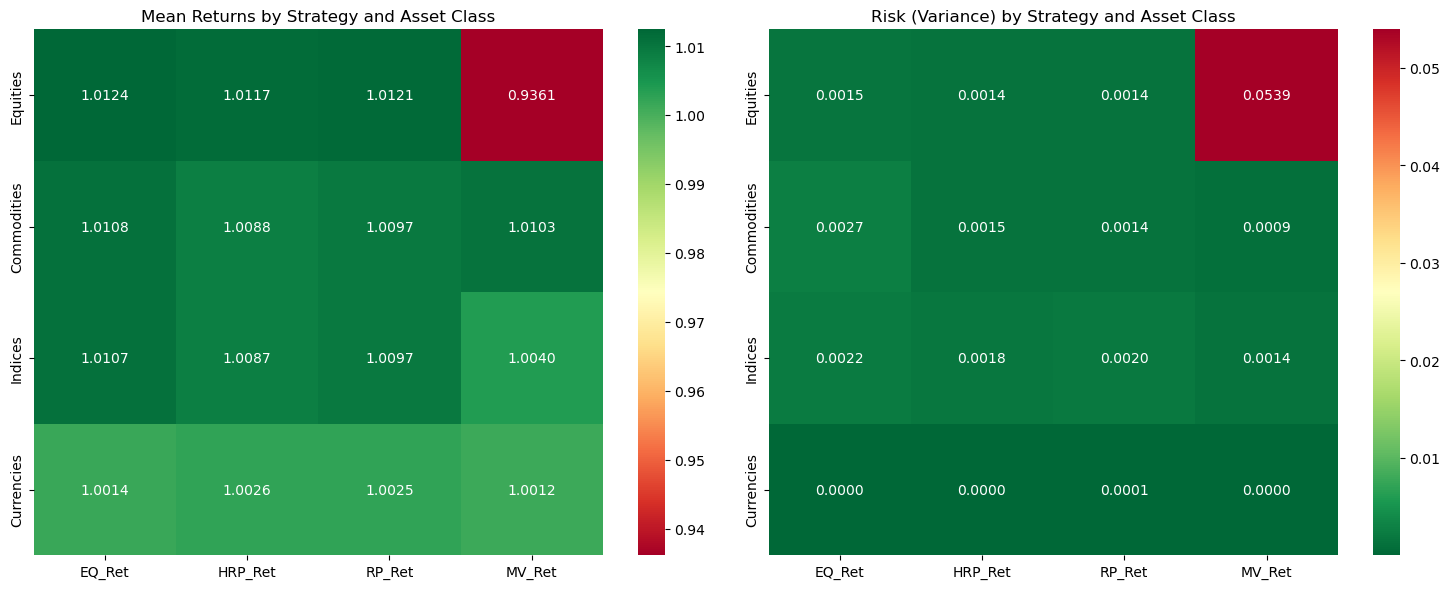

In [28]:
plot_risk_return_heatmap()